In [2]:
# load what we need
library(survival)
library(survminer)
library(drc)
library(tidyverse)
library(coxphf)

In [6]:
gene_silencing_survival = read.csv("gene_silencing_survival.csv")
str(gene_silencing_survival)

'data.frame':	180 obs. of  15 variables:
 $ bee_code : chr  "Hive1_Con.Scram_1" "Hive1_Con.Scram_2" "Hive1_Con.Scram_3" "Hive1_Con.Scram_4" ...
 $ pot_code : chr  "Hive1_Con.Scram" "Hive1_Con.Scram" "Hive1_Con.Scram" "Hive1_Con.Scram" ...
 $ diet     : chr  "Scramble" "Scramble" "Scramble" "Scramble" ...
 $ hive     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ treatment: chr  "Con.Scram" "Con.Scram" "Con.Scram" "Con.Scram" ...
 $ day_0    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_1    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_2    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_3    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_4    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_5    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_6    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ day_7    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ event    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ dod      : int  7 7 7 7 7 7 7 7 7 7 ...


In [7]:
# set factors where needed
gene_silencing_survival$hive <- factor(gene_silencing_survival$hive)
gene_silencing_survival$treatment <- factor(gene_silencing_survival$treatment)
gene_silencing_survival$diet <- factor(gene_silencing_survival$diet)
head(gene_silencing_survival)

,bee_code,pot_code,diet,hive,treatment,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,event,dod
,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Hive1_Con.Scram_1,Hive1_Con.Scram,Scramble,1,Con.Scram,1,1,1,1,1,1,1,1,0,7
2,Hive1_Con.Scram_2,Hive1_Con.Scram,Scramble,1,Con.Scram,1,1,1,1,1,1,1,1,0,7
3,Hive1_Con.Scram_3,Hive1_Con.Scram,Scramble,1,Con.Scram,1,1,1,1,1,1,1,1,0,7
4,Hive1_Con.Scram_4,Hive1_Con.Scram,Scramble,1,Con.Scram,1,1,1,1,1,1,1,1,0,7
5,Hive1_Con.Scram_5,Hive1_Con.Scram,Scramble,1,Con.Scram,1,1,1,1,1,1,1,1,0,7
6,Hive1_Con.Scram_6,Hive1_Con.Scram,Scramble,1,Con.Scram,1,1,1,1,1,1,1,1,0,7


## 1. Using Cox Proportional Hazards to monitor effect of supplementation on survival over 9 days

### 1a - Create propertion dataframe collapsed by pot

In [14]:
# group data by pot
rnai_pot <- subset(gene_silencing_survival, select = -c(bee_code, dod, event))
rnai_pot <- rnai_pot %>% group_by(diet, hive, pot_code, treatment) %>% summarise_all(list("sum" = sum))

# convert frequencies to proportions
rnai_pot[, -(1:4)] <- sweep(rnai_pot[, -(1:4)], unlist(rnai_pot[, "day_0_sum"]), MARGIN = 1, "/")
rnai_pot

diet,hive,pot_code,treatment,day_0_sum,day_1_sum,day_2_sum,day_3_sum,day_4_sum,day_5_sum,day_6_sum,day_7_sum
<fct>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Relish,1,Hive1_Con.RNAi,Con.RNAi,1,1,1,1,1.0,1.0,1.0,1.0
Relish,1,Hive1_Nos.RNAi,Nos.RNAi,1,1,1,1,1.0,1.0,1.0,1.0
Relish,2,Hive2_Con.RNAi,Con.RNAi,1,1,1,1,1.0,1.0,1.0,1.0
Relish,2,Hive2_Nos.RNAi,Nos.RNAi,1,1,1,1,1.0,1.0,1.0,1.0
Relish,3,Hive3_Con.RNAi,Con.RNAi,1,1,1,1,1.0,1.0,1.0,0.9
Relish,3,Hive3_Nos.RNAi,Nos.RNAi,1,1,1,1,1.0,1.0,1.0,1.0
Scramble,1,Hive1_Con.Scram,Con.Scram,1,1,1,1,1.0,1.0,1.0,1.0
Scramble,1,Hive1_Nos.Scram,Nos.Scram,1,1,1,1,1.0,1.0,1.0,1.0
Scramble,2,Hive2_Con.Scram,Con.Scram,1,1,1,1,0.9,0.9,0.9,0.9


### 1b - Make summary survival tables form the pot tables

In [16]:
# now all the calculations are done, we can make a survival table to display the data
rnai.treatment = subset(rnai_pot, select = -c(diet, hive, pot_code))
rnai.treat.sum <- rnai.treatment %>% group_by(treatment) %>% summarise_all(list("mean" = mean))
rnai.treat.sum
# complete survival in Nos.RNAi (one without Relish) which is unexpected, if relish was important you would think that
# bees without it would suffer higher mortality. We will have to find out if this is significant

treatment,day_0_sum_mean,day_1_sum_mean,day_2_sum_mean,day_3_sum_mean,day_4_sum_mean,day_5_sum_mean,day_6_sum_mean,day_7_sum_mean
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Con.RNAi,1,1,1,1,1.0000000,1.0000000,1.0000000,0.9666667
Con.Scram,1,1,1,1,0.9666667,0.9666667,0.9333333,0.9333333
Con.Suc,1,1,1,1,1.0000000,1.0000000,0.9666667,0.9666667
Nos.RNAi,1,1,1,1,1.0000000,1.0000000,1.0000000,1.0000000
Nos.Scram,1,1,1,1,1.0000000,1.0000000,1.0000000,0.9000000
Nos.Suc,1,1,1,1,1.0000000,1.0000000,0.9666667,0.9000000


## 3. Plotting the survival probability data

Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Median survival not reached.”


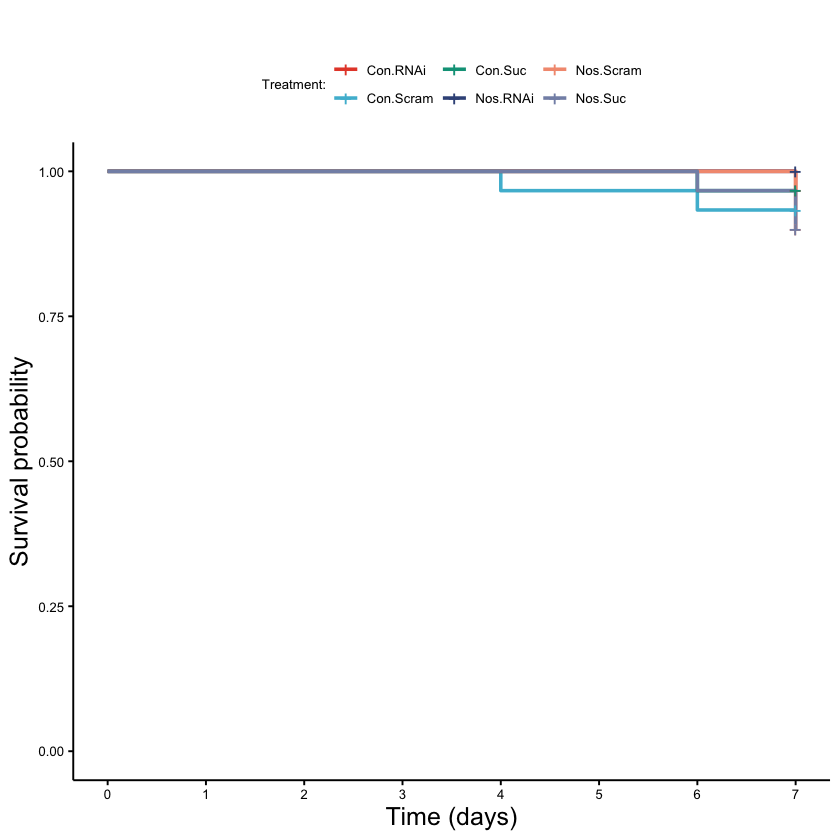

In [18]:
# now we have summarised the data by treatment, it is now time to analyse it
# we can run fit function plots to look at the data

survfit.rnai <- survfit(Surv(dod, event) ~ treatment, data = gene_silencing_survival) 
# this gives a basic view of the data which we can use to generate a figure

# then creat a Kaplan-Meier curve with the nektapoll treatments
km.rnai <- ggsurvplot(survfit.rnai, data = gene_silencing_survival, pval = FALSE, pval.size =3, pval.method = FALSE,
                      pval.coord = c(0.0, 0.1), pval.method.size = 3, pval.method.coord = c(0.0, 0.2),
                      title = "", 
                      font.main = c(16, "bold"), font.y = 15,
                      font.x =15, font.tickslab = 8, xlab = "Time (days)", font.legend=8, legend.labs =
                        c("Con.RNAi", "Con.Scram", "Con.Suc", "Nos.RNAi", "Nos.Scram", "Nos.Suc"), 
                      legend.title = "Treatment:", time.inc = 1, xlim = c(0,7), palette= "npg", linetype = "solid", 
                      surv.median.line = "h", legend = "top", break.time.by = 1)
km.rnai
# not very informative. Only 10 deaths across the whole experiment means that all 
# treatments are pretty close and basically indistinguishable. No.RNAi has the highest
# survival. Can't think it will be significant though given the similarity in mortality

## 4. Statistical Comparison of the treatments

In [22]:
# I will need to run Cox Proportional Hazards with Firth's penalised likelihood here (coxphf) because we had treatments
# with no deaths, which causes monotone likelihood and causes the model not to converge. 
rnai.coxphf <- coxphf(Surv(dod, event) ~ treatment + hive, data = gene_silencing_survival)
rnai.coxphf
# no significant different between treatments, suggesting that over 9 days the Relish gene does not provide any
# enhanced immune response to nosema

coxphf(formula = Surv(dod, event) ~ treatment + hive, data = gene_silencing_survival)
Model fitted by Penalized ML
Confidence intervals and p-values by Profile Likelihood 

                          coef se(coef)  exp(coef)  lower 0.95  upper 0.95
treatmentCon.Scram  0.57672759 1.178342  1.7802033 0.236762097   19.456234
treatmentCon.Suc    0.05580509 1.316562  1.0573916 0.085867027   13.021024
treatmentNos.RNAi  -1.09861200 1.863487  0.3333334 0.002284353    6.248405
treatmentNos.Scram  0.84729811 1.113646  2.3333339 0.383951325   24.071364
treatmentNos.Suc    0.90310315 1.113139  2.4672475 0.405880276   25.456969
hive2               1.11730451 1.752155  3.0566040 0.163045264  446.037621
hive3               2.98267535 1.556921 19.7405590 2.508259900 2545.001867
                          Chisq           p
treatmentCon.Scram  0.322840607 0.569905524
treatmentCon.Suc    0.002334915 0.961460449
treatmentNos.RNAi   0.523248144 0.469459396
treatmentNos.Scram  0.822828785 0.364354392
treatme

In [26]:
# then check that we don't violate assumptions of coxph. BUT as i couldn't run a coxph i will have to create
# a fake coxph model to test the assumptions

rnai.coxphf.validation <- coxph(Surv(dod, event) ~ treatment + hive, data = gene_silencing_survival)
rnai.coxphf.coxassump = cox.zph(rnai.coxphf.validation)
rnai.coxphf.coxassump
# all bigger than 0.05 so no violations there

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  3,6,7 ; coefficient may be infinite. ”


          chisq df    p
treatment  7.68  5 0.17
hive       3.37  2 0.19
GLOBAL    11.13  7 0.13